In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0011473626207233476
1d Y error =  0.0008794100001069905


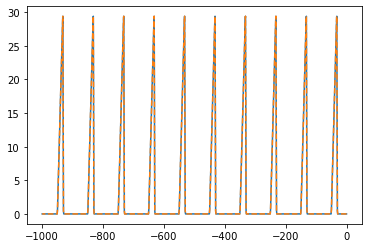

In [3]:
L_x, L_p, x2, x3, h = 1000, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[147.           5.07216     60.09925132 -30.04962566 -24.55897923
 -15.03442615  29.89950206]
sample =  147.0
min loss =  267931.9210377491 L_p, x2, x3, h =  tensor(60.0993) tensor(-24.5590) tensor(-15.0344) tensor(29.8995)


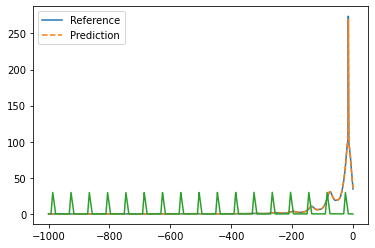

In [4]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)


# nx ny
L_x , N_s = 1000.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()

print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out, "--", label="Prediction")
plt.plot(mesh_X, mesh_Y)
plt.legend()

82373057
0 0.05794028751552105 loss =  272751.25
L_p, x1, x2, x3, h  =  60.09925079345703 -30.049625396728516 -24.55898094177246 -15.034425735473633 29.89950180053711


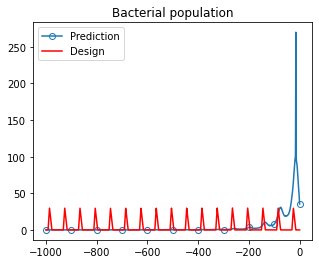

200 0.05484852194786072 loss =  271699.40625
L_p, x1, x2, x3, h  =  60.099246978759766 -30.049623489379883 -24.143917083740234 -15.034157752990723 29.862323760986328


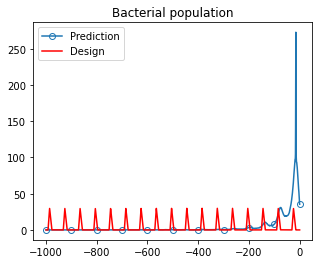

KeyboardInterrupt: 

In [5]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.0001
epochs = 10001
step_size = 1000
gamma = 0.5


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
def transfer(theta):
    
    L_p = 60 + (150 - 60)/(1 + torch.abs(theta[0]))
    x1 = -0.5*L_p
    x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
    h = 20   + (10)/(1 + torch.abs(theta[3]))
    return L_p, x1, x2, x3, h
   
def inv_transfer(L_p, x2, x3, h):
    theta = np.zeros(4)
    theta[0] = (150 - 60)/(L_p - 60) - 1
    theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
    theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
    theta[3] = 10/(h - 20 ) - 1
    return theta

sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
theta0 =    inv_transfer(L_p, x2, x3, h) 

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 1000
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
    
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")